# Predictive Power vs Correlation

Correlation is a statistical method used to assess a possible linear association between two continuous variables. 

It is simple both to calculate and to interpret. However, misuse of correlation is so common among researchers that some statisticians have wished that the method had never been devised at all. 





## From **Robert Ferner**'s "**Are Correlations any Guide to Predictive Value?**"

for more read please go to [Ebook](https://www.jstor.org/stable/2985494?seq=1)

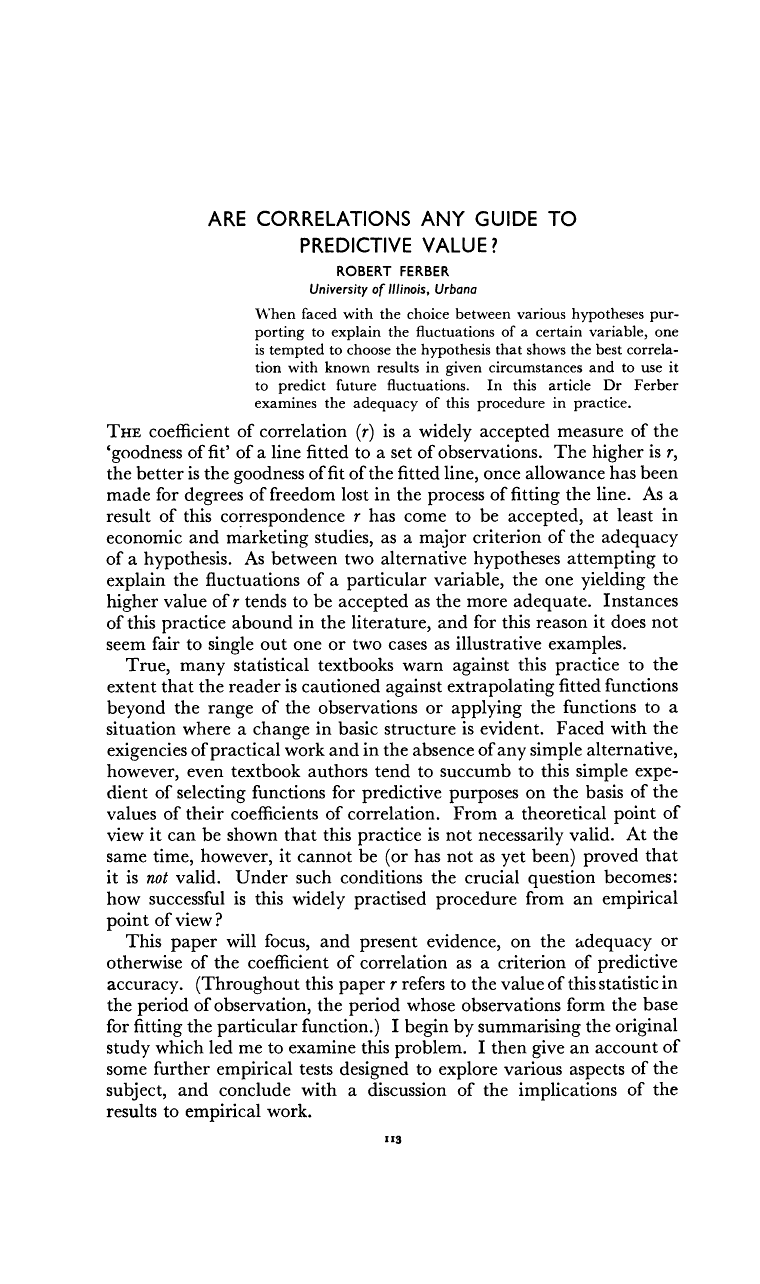

In [ ]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

warnings.filterwarnings("ignore")

From the makers of bamboolib:

The PPS is an asymmetric, data-type-agnostic score that can detect linear or non-linear relationships between two columns. The score ranges from 0 (no predictive power) to 1 (perfect predictive power). It can be used as an alternative to the correlation (matrix).

- Github: https://github.com/8080labs/ppscore

In [ ]:
!pip install ppscore

In [ ]:
import ppscore as pps

In [ ]:
df_train = pd.read_csv('../input/titanic/train.csv')
df_test  = pd.read_csv('../input/titanic/test.csv')
df_sample= pd.read_csv('../input/titanic/gender_submission.csv')

Below, we're doing the preprocessing stages, I didn't give any details about these, if you need please go to https://www.kaggle.com/frtgnn/a-simple-guide-to-titanic-survival-classifier

In [ ]:
dataset_title = [i.split(",")[1].split(".")[0].strip() for i in df_train["Name"]]
df_train["Title"] = pd.Series(dataset_title)
df_train["Title"] = df_train["Title"].replace(['Lady', 'the Countess','Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
df_train["Title"] = df_train["Title"].map({"Master":0, "Miss":1, "Ms" : 1 , "Mme":1, "Mlle":1, "Mrs":1, "Mr":2, "Rare":3})
df_train["Title"] = df_train["Title"].astype(int)
df_train.drop(labels = ["Name"], axis = 1, inplace = True)

sex = pd.get_dummies(df_train['Sex'],drop_first=True)
embark = pd.get_dummies(df_train['Embarked'],drop_first=True)
df_train = pd.concat([df_train,sex,embark],axis=1)

df_train["Family"] = df_train["SibSp"] + df_train["Parch"] + 1
df_train['Single'] = df_train['Family'].map(lambda s: 1 if s == 1 else 0)
df_train['SmallF'] = df_train['Family'].map(lambda s: 1 if  s == 2  else 0)
df_train['MedF']   = df_train['Family'].map(lambda s: 1 if 3 <= s <= 4 else 0)
df_train['LargeF'] = df_train['Family'].map(lambda s: 1 if s >= 5 else 0)
df_train['Senior'] = df_train['Age'].map(lambda s:1 if s>60 else 0)

def get_person(passenger):
    age,sex = passenger
    return 'child' if age < 16 else sex

df_train['Person'] = df_train[['Age','Sex']].apply(get_person,axis=1)

person_dummies_train  = pd.get_dummies(df_train['Person'])
person_dummies_train.columns = ['Child','Female','Male']
person_dummies_train.drop(['Male'], axis=1, inplace=True)

df_train = df_train.join(person_dummies_train)

df_train.drop(['Person'],axis=1,inplace=True)
df_train.drop('male',axis=1,inplace=True)
df_train.drop(['Cabin','Ticket'],axis = 1, inplace= True)
df_train.drop(['Sex','Embarked'],axis=1,inplace=True)
df_train.drop(['PassengerId'],axis=1,inplace=True)

df_train.head()

# Predictive Score

In [ ]:
plt.figure(figsize=(16,12))
sns.heatmap(pps.matrix(df_train),annot=True,fmt=".2f")

# Correlation

In [ ]:
plt.figure(figsize=(16,12))
sns.heatmap(df_train.corr(),annot=True,fmt=".2f")

These explanations are taken from the creators' [GITHUB](https://github.com/8080labs/ppscore) 

### Calculation of the PPS

There are multiple ways how you can calculate the PPS. The ppscore package provides a sample implementation that is based on the following calculations:

- The score is calculated using only 1 feature trying to predict the target column. This means there are no interaction effects between the scores of various features. Note that this is in contrast to feature importance
- The score is calculated on the test sets of a 4-fold crossvalidation (number is adjustable via ppscore.CV_ITERATIONS)
- All rows which have a missing value in the feature or the target column are dropped
- In case that the dataset has more than 5,000 rows the score is only calculated on a random subset of 5,000 rows with a fixed random seed (ppscore.RANDOM_SEED). You can adjust the number of rows or skip this sampling via the API. However, in most scenarios the results will be very similar.
- There is no grid search for optimal model parameters

### Learning algorithm

As a learning algorithm, we currently use a Decision Tree because the Decision Tree has the following properties:

- can detect any non-linear bivariate relationship
- good predictive power in a wide variety of use cases
- low requirements for feature preprocessing
- robust model which can handle outliers and does not easily overfit
- can be used for classification and regression
- can be calculated quicker than many other algorithms

We differentiate the exact implementation based on the data type of the target column:

- If the target column is numeric, we use the sklearn.DecisionTreeRegressor
- If the target column is categoric, we use the sklearn.DecisionTreeClassifier

Please note that we prefer a general good performance on a wide variety of use cases over better performance in some narrow use cases. If you have a proposal for a better/different learning algorithm, please open an issue

However, please note why we actively decided against the following algorithms:

- Correlation or Linear Regression: cannot detect non-linear bivariate relationships without extensive preprocessing
- GAMs: might have problems with very unsmooth functions
- SVM: potentially bad performance if the wrong kernel is selected
- Random Forest/Gradient Boosted Tree: slower than a single Decision Tree
- Neural Networks and Deep Learning: slower calculation than a Decision Tree and also needs more feature preprocessing

### Data preprocessing

Even though the Decision Tree is a very flexible learning algorithm, we need to perform the following preprocessing steps if a column has the pandas dtype object.‌

- If the target column is categoric, we use the sklearn.LabelEncoder​
- If the feature column is categoric, we use the sklearn.OneHotEncoder​

### Inference of the prediction task

The choice of the task (classification or regression) has an influence on the final PPS and thus it is important how the task is chosen. If you calculate a single score, you can pass in a specific task. If you do not specify the task, the task is inferred as follows.

A **classification** is inferred if one of the following conditions meet:

- the target has the dtype object or categorical
- the target only has two unique values
- the target is numeric but has less than 15 unique values. This breakpoint can be overridden via the constant ppscore.NUMERIC_AS_CATEGORIC_BREAKPOINT

Otherwise, the task is inferred as regression if the dtype is numeric (float or integer).

### Tasks and their score metrics​

Based on the data type and cardinality of the target column, ppscore assumes either the task of a classification or regression. Each task uses a different evaluation score for calculating the final predictive power score (PPS).

### Regression

In case of an regression, the ppscore uses the mean absolute error (MAE) as the underlying evaluation metric (MAE_model). The best possible score of the MAE is 0 and higher is worse. As a baseline score, we calculate the MAE of a naive model (MAE_naive) that always predicts the median of the target column. The PPS is the result of the following normalization (and never smaller than 0):

#### PPS = 1 - (MAE_model / MAE_naive)

### Classification

If the task is a classification, we compute the weighted F1 score (wF1) as the underlying evaluation metric (F1_model). The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. The relative contribution of precision and recall to the F1 score are equal. The weighted F1 takes into account the precision and recall of all classes weighted by their support as described here. As a baseline score, we calculate the weighted F1 score of a naive model (F1_naive) that always predicts the most common class of the target column. The PPS is the result of the following normalization (and never smaller than 0):

#### PPS = (F1_model - F1_naive) / (1 - F1_naive)


# bonus: Does Correlation Imply Prediction?

A nice read about this topic, and in the comments discussions

https://neuroneurotic.net/2015/11/30/does-correlation-imply-prediction/